# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [8]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df = pd.read_csv("bikes_rent.csv", encoding="utf-8")
df.head(5)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

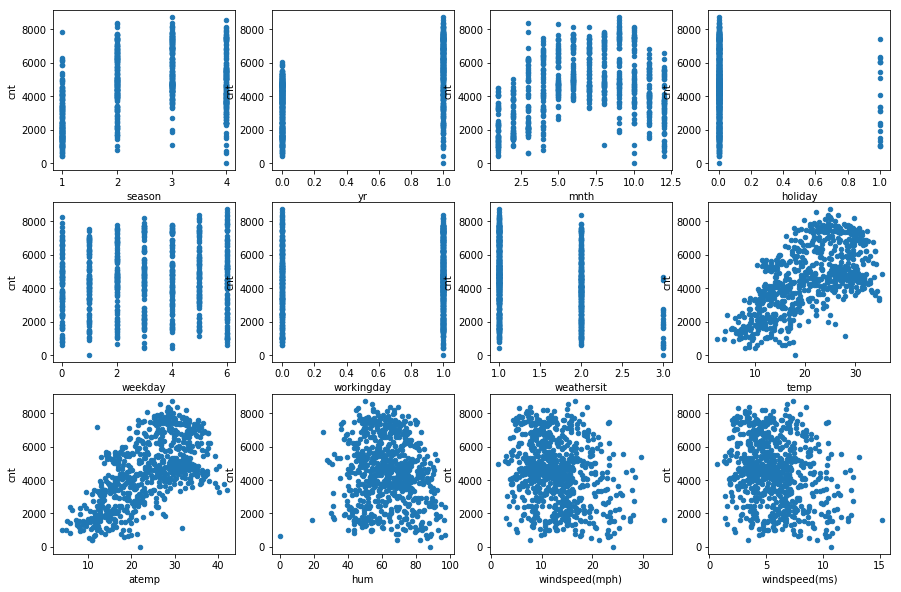

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: зависимость отображена на рис №1. Прослеживается явная зависимость, которую можно апроксимировать кривой второй степени (зависимость **НЕ**линейная).
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: признаки, линейно влияющие на кол-во прокаторв, отмечаны желты фоном на рис.№2. Это **yr, holiday, workingday** и **weathersit**.

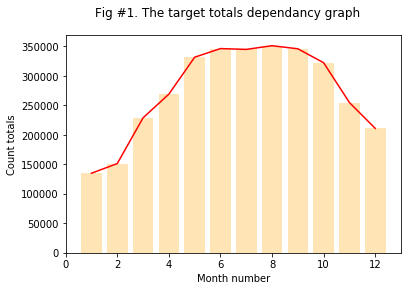

In [10]:
target_grouped_by_mnth = df[["mnth", "cnt"]].groupby(["mnth"]).sum()
plt.figure().suptitle("Fig #1. The target totals dependancy graph")
plt.plot(target_grouped_by_mnth.index,target_grouped_by_mnth["cnt"],"r-")
plt.xlabel("Month number")
plt.ylabel("Count totals")
plt.bar(target_grouped_by_mnth.index,target_grouped_by_mnth["cnt"], color = "moccasin")
plt.show()

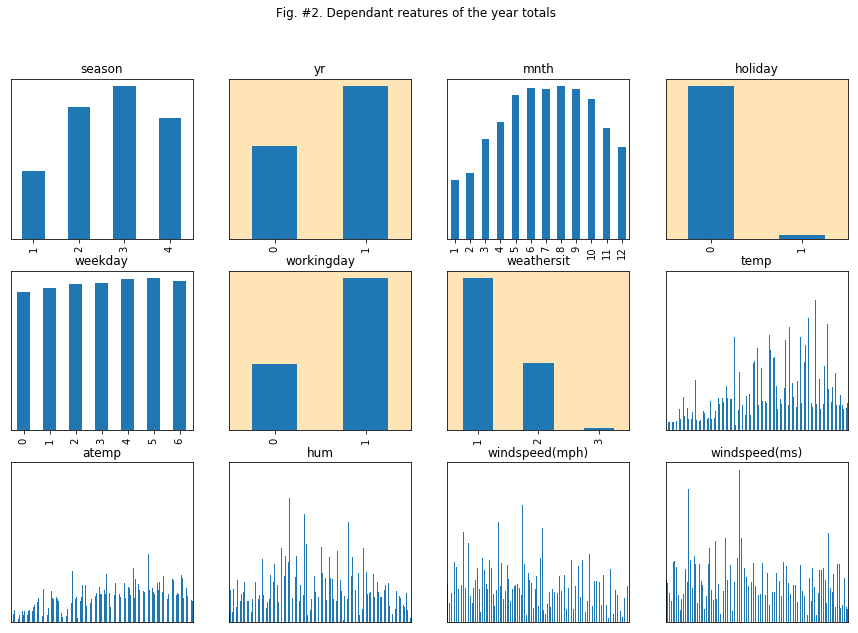

In [11]:
df_features_column_names = df.columns[:-1]
df_target_column_name = df.columns[-1:][0]

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

fig.suptitle("Fig. #2. Dependant reatures of the year totals")

for idx, column in enumerate(df_features_column_names):
    res_df = df[[column, df_target_column_name]].groupby([column]).sum()
    axis_cell = res_df.plot(use_index=True, y=df_target_column_name, kind="bar",
                subplots=False, ax=axes[idx / 4, idx % 4], title=column, legend=False)
    axis_cell.set_xlabel("")
    axis_cell.set_ylabel("")
    axis_cell.set_yticks([])
    axis_cell.set_facecolor("white")
    if idx>6:
        axis_cell.set_xticks([])
        
    if idx in[1,3,5,6]:
        axis_cell.set_facecolor("moccasin")

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [13]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:

df_features = df[df.columns[:-1]]
df_target =  df[df.columns[-1:]]

target_data = df_target.values.copy().T[0]

dict_target_data = dict()
for col in df_features_column_names:
    dict_target_data[col] = target_data

df_target_dup = pd.DataFrame(dict_target_data, columns=df_features_column_names)

print "Features values:\n", df_features.head(10)

print "\nTarget values:\n", df_target.head(10)


print "\n\nSpecial dataframe with duplicated target values and same column names, as in features dataframe:\n", 
df_target_dup.head(10)


corr_values = df_features.corrwith(other=df_target_dup, axis=0, method="pearson")
res_df = pd.DataFrame(corr_values, columns=["value"])
res_df["abs_value"] = res_df["value"].map(lambda x: abs(x))

result_bins = [0., 0.1, 0.2, 0.3, 0.6, 0.9, 1.]
result_labels = ["Negligible", "Weak", "Moderate", "Strong", "Very strong", "Perfect" ]

res_df["interpretation"] = pd.cut(res_df["abs_value"], bins= result_bins, labels=result_labels)

res_df.sort_values(ascending=False,inplace=True,by="abs_value")
print "\n\nThe correlation matrix: \n", res_df



Features values:
   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   
5       1   0     1        0        4           1           1   8.378268   
6       1   0     1        0        5           1           2   8.057402   
7       1   0     1        0        6           0           2   6.765000   
8       1   0     1        0        0           0           1   5.671653   
9       1   0     1        0        1           1           1   6.184153   

      atemp      hum  windspeed(mph)  windspeed(ms)  
0  18.18125  80.5833       10.749882       4.805490  
1  17.68695  69.6087       16.652113  

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [14]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
corr_feature_names = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]
corr_target_name = ["cnt"]
corr_df_subset = df[corr_feature_names + corr_target_name]
print corr_df_subset.corr(method="pearson")

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [15]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
print df_features.mean()

season             2.496580
yr                 0.500684
mnth               6.519836
holiday            0.028728
weekday            2.997264
workingday         0.683995
weathersit         1.395349
temp              20.310776
atemp             23.717699
hum               62.789406
windspeed(mph)    12.762576
windspeed(ms)      5.705220
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [16]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [17]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

C:\Users\avikulin\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
regr = LinearRegression()
regr.fit(df_features, df_target)
print "Regression coefficients:\n", zip(df_features.columns, regr.coef_[0])

Regression coefficients:
[(u'season', 514.2738928880804), (u'yr', 2043.9354216394006), (u'mnth', -40.96322978530537), (u'holiday', -519.3858244882628), (u'weekday', 68.49560064250068), (u'workingday', 121.29483840239848), (u'weathersit', -606.4573140544759), (u'temp', 48.99748966005964), (u'atemp', 71.91300711674711), (u'hum', -10.230301007030485), (u'windspeed(mph)', 2400806037064.389), (u'windspeed(ms)', -5370603104997.84)]


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [20]:
from sklearn.linear_model import Lasso, Ridge

In [21]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса
lasso_regression = Lasso()
lasso_regression.fit(df_features, df_target)
print "Lasso regression coefficients:\n\n", zip(df_features.columns, lasso_regression.coef_)

Lasso regression coefficients:

[(u'season', 506.5512786498077), (u'yr', 2036.2316676979037), (u'mnth', -38.07827028932166), (u'holiday', -484.651946186541), (u'weekday', 68.93837479133965), (u'workingday', 118.44759758668356), (u'weathersit', -604.5667118927048), (u'temp', 51.3632605856165), (u'atemp', 69.91273749012177), (u'hum', -10.352705204636573), (u'windspeed(mph)', -38.34106761310848), (u'windspeed(ms)', -0.0)]


In [22]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса

ridge_regression = Ridge()
ridge_regression.fit(df_features, df_target)
print "Ridge regression coefficients:\n\n", zip(df_features.columns, ridge_regression.coef_[0])

Ridge regression coefficients:

[(u'season', 507.8018818505662), (u'yr', 2029.0890541970482), (u'mnth', -38.47089727912181), (u'holiday', -493.27801548381973), (u'weekday', 69.11396965165969), (u'workingday', 121.52442502929445), (u'weathersit', -605.2055553731515), (u'temp', 49.31676759598135), (u'atemp', 71.78598727335148), (u'hum', -10.3833945004847), (u'windspeed(mph)', -31.935501694384467), (u'windspeed(ms)', -14.276040263618992)]


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [23]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.

print "\n\nData:"

for idx, alpha_value in enumerate(alphas):
    ridge_regressor = Ridge(alpha=alpha_value)
    lasso_regressor = Lasso(alpha=alpha_value)
    
    ridge_regressor.fit(df_features, df_target)
    lasso_regressor.fit(df_features, df_target)
    
    coefs_ridge[idx, :] = ridge_regressor.coef_[0]
    coefs_lasso[idx, :] = lasso_regressor.coef_
    
    
    
print "\nRidge - "
print coefs_ridge

print "\n\nLasso - "
print coefs_lasso




Data:

Ridge - 
[[ 5.07801882e+02  2.02908905e+03 -3.84708973e+01 -4.93278015e+02
   6.91139697e+01  1.21524425e+02 -6.05205555e+02  4.93167676e+01
   7.17859873e+01 -1.03833945e+01 -3.19355017e+01 -1.42760403e+01]
 [ 4.20961039e+02  1.58131963e+03 -1.54666572e+01 -1.46436955e+02
   6.61233153e+01  1.06998998e+02 -4.10178573e+02  4.81667970e+01
   7.87848784e+01 -1.72880397e+01 -3.63843103e+01 -1.62647789e+01]
 [ 3.59764921e+02  1.29619343e+03  6.55388629e-01 -8.78675953e+01
   6.29289055e+01  8.59931572e+01 -3.08794909e+02  4.95374888e+01
   8.10569091e+01 -2.11171036e+01 -3.89562780e+01 -1.74145186e+01]
 [ 3.14968392e+02  1.09838252e+03  1.22882375e+01 -6.32736101e+01
   6.04583742e+01  7.14707987e+01 -2.47032358e+02  5.10818939e+01
   8.20094836e+01 -2.35447825e+01 -4.06259577e+01 -1.81609109e+01]
 [ 2.80752194e+02  9.53038154e+02  2.10375931e+01 -4.96305946e+01
   5.84618794e+01  6.10971906e+01 -2.05646363e+02  5.25203101e+01
   8.23950213e+01 -2.52161534e+01 -4.17932767e+01 -1.8

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5,1,'Ridge')

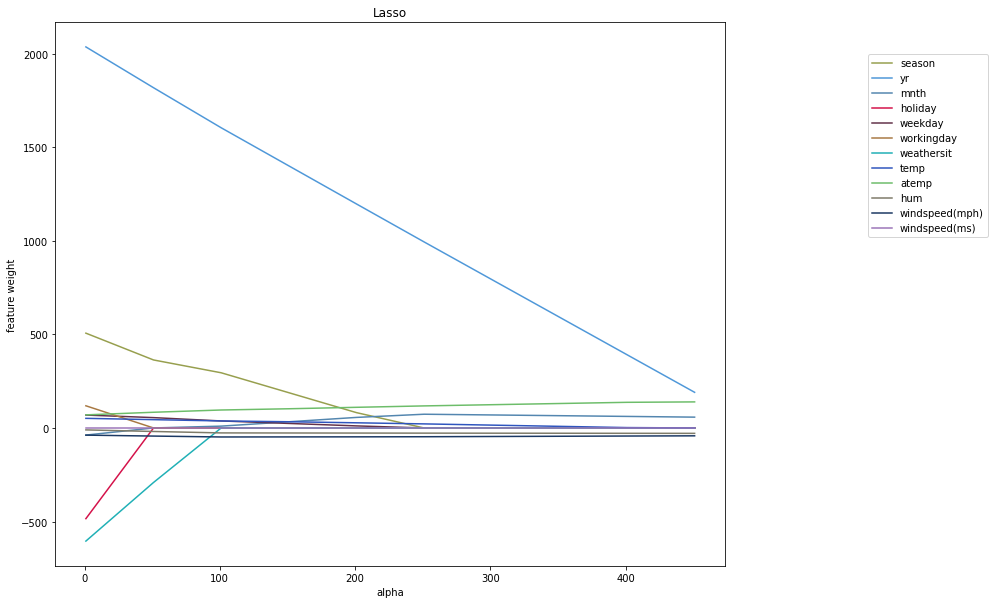

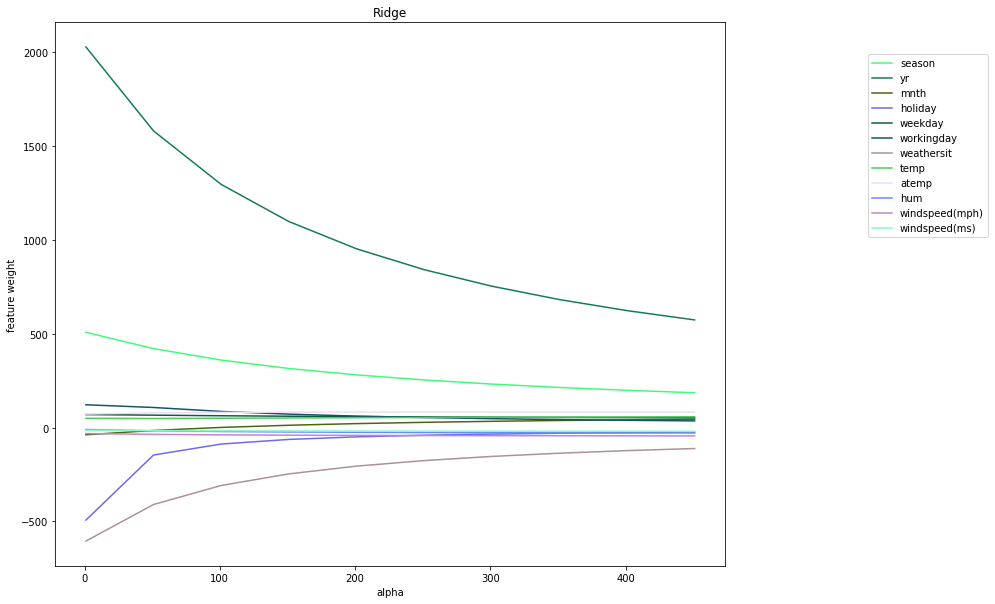

In [24]:
plt.figure(figsize=(12, 10))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(12, 10))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

     Ridge  Lasso
1        0      1
51       0      4
101      0      4
151      0      4
201      0      4
251      0      6
301      0      6
351      0      6
401      0      6
451      0      7


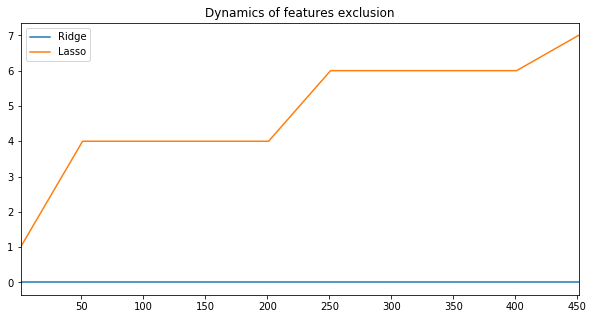

In [25]:
counter_func = lambda values: len(values) - np.count_nonzero(values)

ridge_coefs_df = pd.DataFrame(index=alphas, columns=df_features.columns, data=coefs_ridge)
ridge_coefs_df["ZeroCount"] = ridge_coefs_df.apply(axis=1, func= counter_func)
                                                   
lasso_coefs_df = pd.DataFrame(index=alphas, columns=df_features.columns, data=coefs_lasso)
lasso_coefs_df["ZeroCount"] = lasso_coefs_df.apply(axis=1, func= counter_func)

compare_df = pd.concat([ridge_coefs_df["ZeroCount"],lasso_coefs_df["ZeroCount"]], 
                       axis=1, join = "inner")

compare_df.columns = ["Ridge", "Lasso"]
print compare_df.head(10)

compare_df.plot(use_index=True, kind="line",figsize=(10,5), 
                title = "Dynamics of features exclusion", legend=True)

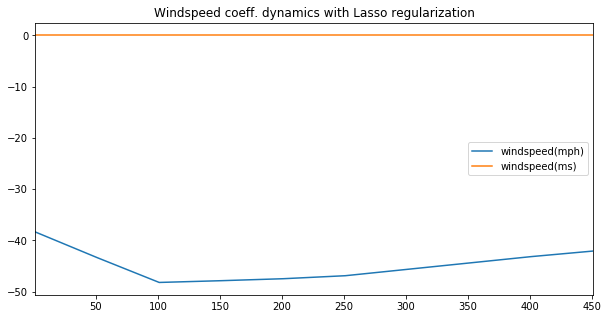

In [26]:
lasso_coefs_df.plot(use_index=True, y=["windspeed(mph)","windspeed(ms)"], figsize=(10,5),
                    kind="line", legend=True, title="Windspeed coeff. dynamics with Lasso regularization")

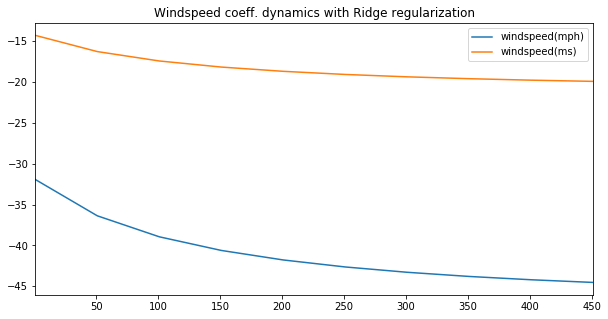

In [27]:
ridge_coefs_df.plot(use_index=True, y=["windspeed(mph)","windspeed(ms)"], figsize=(10,5),
                    kind="line", legend=True, title="Windspeed coeff. dynamics with Ridge regularization")

**ВЫВОД:**
По сравнению с L2, L1-регуляризация имеет форму кристалла, причем веса уменьшаются в его вершинах. Данные вершины показывают, в каких точках поверхности коэффициент соответствующего признака равен нулю, аннулирая таким образом влияние данного признака на целевую переменную. При этом, поверхность L2-регуляризатора является гладкой и дифференцируемой во всех точках, в то время как поверхность L1 имеет грани и не имеет производной в точках, расположенных на них.

В рузультате применения данных регуляризаторов можно подитожить:
* L2 старается максимально сократить все веса в совокупности.
* L1 старается объединить все признаки в один доминирующий, т.е. занулить признаки с наименьшим влиянием.


Источник - http://laid.delanover.com/difference-between-l1-and-l2-regularization-implementation-and-visualization-in-tensorflow/

"...In contrast, L1 regularization’s shape is diamond-like and the weights are lower in the corners of the diamond. These corners show where one of the axis/feature is zero thus leading to sparse matrices. Note how the shapes of the functions shows their differentiability: L2 is smooth and differentiable and L1 is sharp and non-differentiable.

In few words, L2 will aim to find small weight values whereas L1 could put all the values in a single feature..."

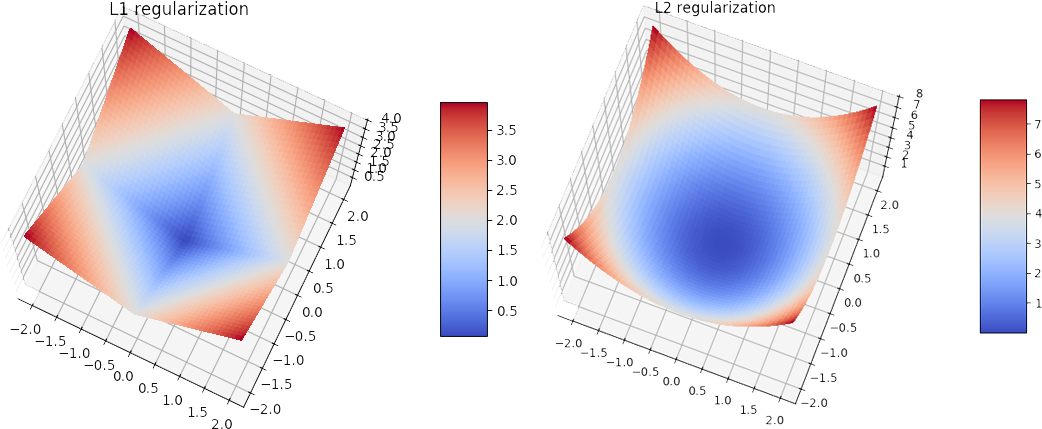

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: **Lasso уменьшает коэффициенты агрессивнее. См. иллюстрацию #1 выше. На ней график количества исключенных признаков в зависимости от роста коэффициента регуляризации.**
    
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: **Модель станет константной, т.е. будут исключены абсолютно все признаки.**
    
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: **да. Один из линейно-зависимых признаков сразу исключается L1-регуляризатором. См. иллюстрацию #2 и #3 выше.**

1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: **Только L1-регуляризатор, т.е. Lasso**

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [28]:
from sklearn.linear_model import LassoCV

In [31]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов

alphas = np.arange(1, 100, 5)

lasso_cv_regressor = LassoCV(alphas=alphas.ravel(),cv=3)
lasso_cv_regressor.fit(df_features, df_target)

lasso_cv_mse_df = pd.DataFrame(index=lasso_cv_regressor.alphas_, data=lasso_cv_regressor.mse_path_)

lasso_cv_mse_df.columns = ["Fold #{0}".format(col) for col in lasso_cv_mse_df.columns]    

print "\nMSE metrics:"
print lasso_cv_mse_df
# print lasso_cv_mse_df.sort_index()


MSE metrics:
         Fold #0        Fold #1       Fold #2
96  1.590460e+06  669885.424217  2.008647e+06
91  1.512733e+06  659818.708631  1.943536e+06
86  1.437081e+06  650525.436044  1.878648e+06
81  1.369787e+06  641960.465518  1.816917e+06
76  1.307213e+06  634117.662909  1.758340e+06
71  1.247833e+06  626991.841325  1.702919e+06
66  1.191646e+06  620615.314129  1.650652e+06
61  1.138652e+06  615030.705660  1.601532e+06
56  1.088852e+06  610130.404842  1.555574e+06
51  1.042245e+06  606705.650674  1.512771e+06
46  9.993146e+05  606812.021044  1.473122e+06
41  9.598454e+05  610504.764984  1.436629e+06
36  9.237571e+05  617783.433887  1.403291e+06
31  8.910495e+05  628605.649039  1.373107e+06
26  8.617228e+05  641177.025987  1.346078e+06
21  8.373884e+05  657592.629658  1.322204e+06
16  8.179601e+05  677852.671963  1.299072e+06
11  8.024570e+05  701957.740160  1.278594e+06
6   7.908783e+05  723492.495139  1.255542e+06
1   7.832212e+05  750269.119203  1.234577e+06


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Metrics of MSE per each CV-fold:

Fold #Fold #0. Min. MSE metric value = 783221.200732 (alpha=1)
Fold #Fold #1. Min. MSE metric value = 606705.650674 (alpha=51)
Fold #Fold #2. Min. MSE metric value = 1234577.17756 (alpha=1)


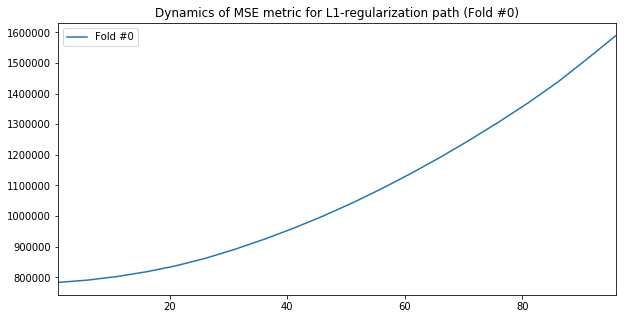

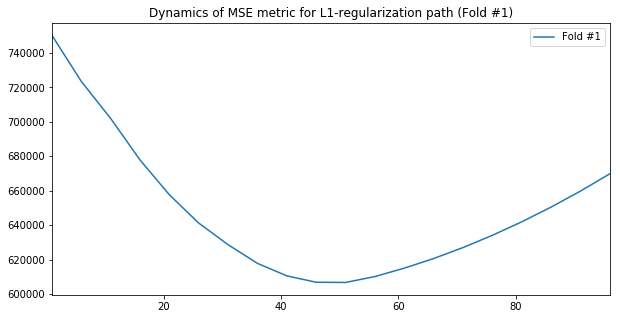

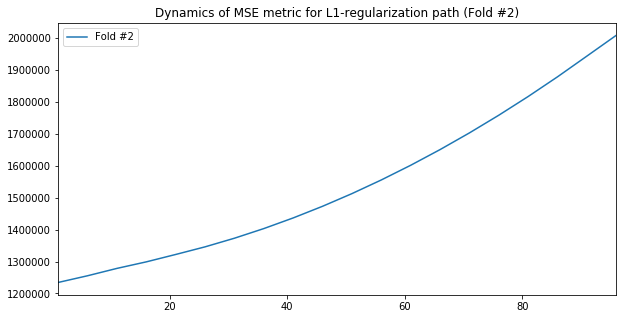

In [32]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
print ("Metrics of MSE per each CV-fold:\n")
for column in lasso_cv_mse_df.columns:
    print "Fold #{0}. Min. MSE metric value = {1} (alpha={2})".format(column, 
                                                                   lasso_cv_mse_df[column].min(), 
                                                                   lasso_cv_mse_df[column].idxmin())

    lasso_cv_mse_df.plot(use_index=True, y=[column], figsize=(10,5),
                    kind="line", legend=True, 
                    title="Dynamics of MSE metric for L1-regularization path ({0})".format(column))

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * **Ответ**: Последняя обученная модель - это L1-регуляризатор с alpha=1. Данная модель показывает, что наибольшее положительное влияние на результат аренды велосипедов оказывают признаки "yr", "season", "workingday" и "atemp" (см. иллюстрацию ниже). При этом признаки "yr" и "workingday" прослеживаются визуально при анализе п.1.2 задания. Зависимость признака "season" линейна на интервале (1,3), а на интервале (3,4) - зависимость меняется. Поэтому данный признак не был выделен изначально при визуальном анализе. Также при визуальном анализе (п.2) не был выделен признак "atemp" в силу того, что график носит "рваный" характер и зависимость неочевидна.
    
    
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: Последняя обученная модель (L1, alpha=1) показывает, что наибольший отрицательный вклад в заказы на аренду велосипедов вносят признаки "holiday","weathersit" и "windspeed(mph)" (см. иллюстрацию ниже). При визуальном анализе в п.1.2 не был выделен признак "windspeed(mph)" в силу того, что график носит "рваный" характер и зависимость неочевидна.
    
    
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: Последняя обученная модель (L1, alpha=1) исключила признак "windspeed(ms)" в силу его линейной зависимости с признаком "windspeed(mph)", о чем говорит высокий коэффициент их паной корреляции (п.1.3):

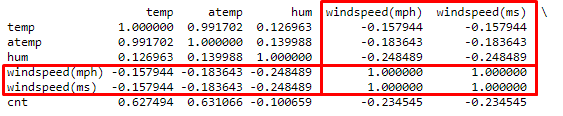

In [33]:
df_analytics = pd.DataFrame(index=df_features.columns, data=lasso_cv_regressor.coef_, columns=["Coeff."])
print "Features with max. positive coefficients:\n"
print df_analytics.sort_values(by="Coeff.", axis=0, ascending=False)["Coeff."][:4]

Features with max. positive coefficients:

yr            2036.231668
season         506.551279
workingday     118.447598
atemp           69.912737
Name: Coeff., dtype: float64


In [34]:
print "Features with max. negative coefficients:\n"
print df_analytics.sort_values(by="Coeff.", axis=0, ascending=True)["Coeff."][:3]

Features with max. negative coefficients:

weathersit       -604.566712
holiday          -484.651946
windspeed(mph)    -38.341068
Name: Coeff., dtype: float64


In [35]:
print "Features with near-zero coefficients:\n"
df_analytics["IsZero"] = df_analytics.apply(axis=1, func= lambda x: abs(x)<1e-3)
print df_analytics.loc[df_analytics["IsZero"]==True].filter(items=["Coeff."])

Features with near-zero coefficients:

               Coeff.
windspeed(ms)    -0.0


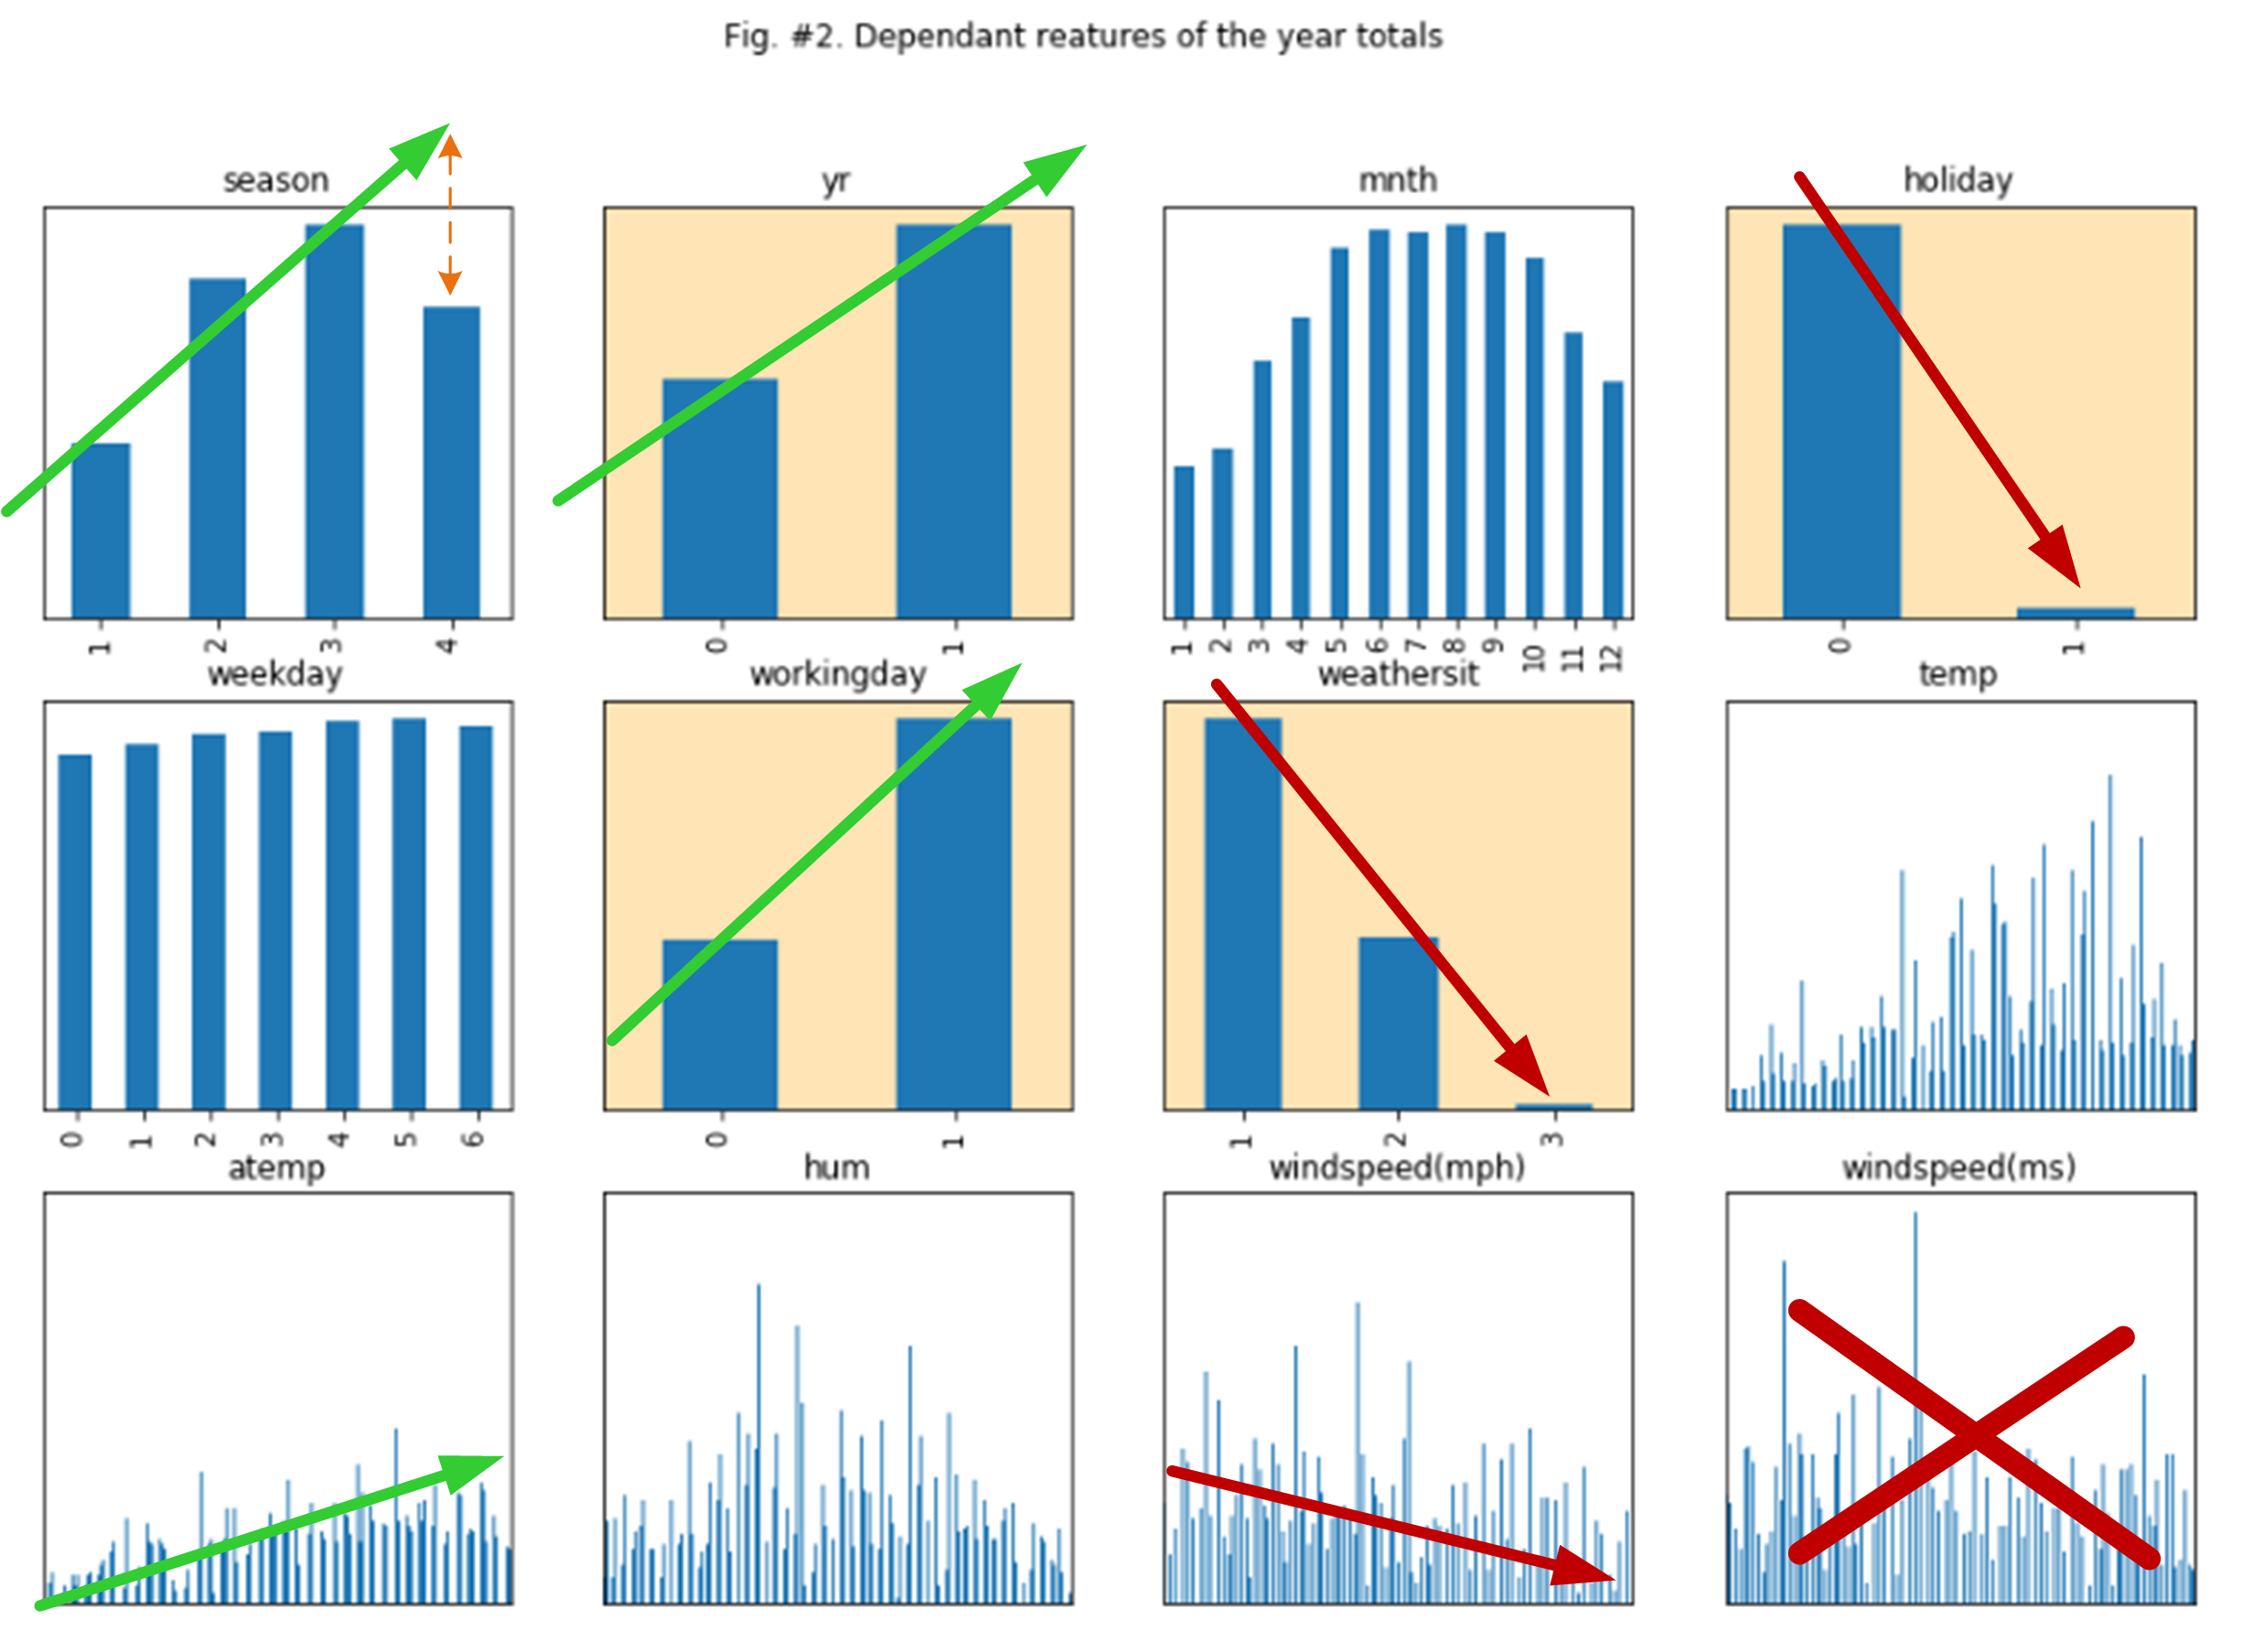

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.